In [11]:
from numpy import random
from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
import io
import re
import unicodedata
import string
import numpy as np
import pandas as pd

In [9]:
# Setup for tokenization/lemma/stem/stop word removal
!pip install -q wordcloud
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
from google.colab import files

# Upload desired datasets
uploaded = files.upload()

Saving rhino_twitter_data_1.csv to rhino_twitter_data_1.csv


In [4]:
# -----------------------------------------------------------------------------
# This cell contains functions to read and cleanup a dataset
# -----------------------------------------------------------------------------
def read_and_cleanup_dataset(filename):
  # Read dataset into dataframe
  tweets = pd.read_csv(filename)

  # Drop none English tweets, comment out if pre-processed
  tweets = tweets[tweets.lang == "en"]
  tweets.reset_index(drop=True, inplace=True)

  # Define patterns to be excluded, currently the following:
  # special characters, @someone, &sth, rt, new line, link, any extra space
  pattern = r'[!@#\$%\^&\*\(\)\[\]{};:\'",.<>/?\\|_~`-]+|@\w+|&\w+|rt|\n|https://\S+'

  # pattern for white space
  ws = r'\s+'

  # non-ASCII specific quotes
  quotes_to_remove = ['“', '”', '‘', '‛', '’']

  # Define emoji patterns to be excluded
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # Emojis in the first group
                           u"\U0001F300-\U0001F5FF"  # Emojis in the second group
                           u"\U0001F680-\U0001F6FF"  # Emojis in the third group
                           u"\U0001F700-\U0001F77F"  # Emojis in the fourth group
                           u"\U0001F780-\U0001F7FF"  # Emojis in the fifth group
                           u"\U0001F800-\U0001F8FF"  # Emojis in the sixth group
                           u"\U0001F900-\U0001F9FF"  # Emojis in the seventh group
                           u"\U0001FA00-\U0001FA6F"  # Emojis in the eighth group
                           u"\U0001FA70-\U0001FAFF"  # Emojis in the ninth group
                           u"\U0001F200-\U0001F251"  # Emojis in the tenth group
                           u"\U0001F004-\U0001F0CF"  # Additional emojis
                           u"\U0001F10D-\U0001F10F"  # Additional emojis
                           u"\U0001F30D-\U0001F567"  # Additional emojis
                           "]+", flags=re.UNICODE)

  # Perform lower casing and remove any patterns
  tweets['tweet'] = tweets['tweet'].apply(str.lower)
  tweets['tweet'] = tweets['tweet'].str.replace(pattern, '', regex=True)
  tweets['tweet'] = tweets['tweet'].apply(lambda x: emoji_pattern.sub(r'', x))
  tweets['tweet'] = tweets['tweet'].str.replace(ws, ' ', regex=True).str.strip()
  for quote in quotes_to_remove:
    tweets['tweet'] = tweets['tweet'].str.replace(quote, '')

  return tweets

In [12]:
fn = 'rhino_twitter_data_1.csv'
tweets = read_and_cleanup_dataset(io.BytesIO(uploaded[fn]))
li_tweets = tweets['tweet'].tolist()
print(tweets['tweet'].head().to_string())
print()
print("len(li_tweets):", len(li_tweets))

0    leedsrhinos rohan smith has named his 21 man s...
1    olpejeta happy valentines daytheres no better ...
2    jackiec49305942 nikki haley announces presiden...
3    carolinadarren no i will vote for ron desantis...
4    bosnerdley chris christie is the biggest rhino...

len(li_tweets): 95026


In [13]:
# Constants
# POS (Parts Of Speech) for: nouns, adjectives, verbs and adverbs
DI_POS_TYPES = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
POS_TYPES = list(DI_POS_TYPES.keys())

# Constraints on tokens
MIN_STR_LEN = 3
RE_VALID = '[a-zA-Z]'

In [19]:
# -----------------------------------------------------------------------------
# This cell contains functions to perform tokenization and remove stop words
# -----------------------------------------------------------------------------
# Get stopwords, stemmer and lemmatizer
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('rhino')
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Remove accents function
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")

# Process all quotes
li_tokens = []
li_token_lists = []
li_lem_strings = []

for i,text in enumerate(li_tweets):
    # Tokenize by sentence, then by lowercase word
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # Process all tokens per quote
    li_tokens_quote = []
    li_tokens_quote_lem = []
    for token in tokens:
        # Remove accents
        t = remove_accents(token)

        # Remove punctuation
        t = str(t).translate(string.punctuation)
        li_tokens_quote.append(t)

        # Add token that represents "no lemmatization match"
        li_tokens_quote_lem.append("-") # this token will be removed if a lemmatization match is found below

        # Process each token
        if t not in stopwords:
            if re.search(RE_VALID, t):
                if len(t) >= MIN_STR_LEN:
                    # Note that the POS (Part Of Speech) is necessary as input to the lemmatizer
                    # (otherwise it assumes the word is a noun)
                    pos = nltk.pos_tag([t])[0][1][:2]
                    pos2 = 'n'  # set default to noun
                    if pos in DI_POS_TYPES:
                      pos2 = DI_POS_TYPES[pos]

                    stem = stemmer.stem(t)
                    lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS

                    if pos in POS_TYPES:
                        li_tokens.append((t, stem, lem, pos))

                        # Remove the "-" token and append the lemmatization match
                        li_tokens_quote_lem = li_tokens_quote_lem[:-1]
                        li_tokens_quote_lem.append(lem)

    # Build list of token lists from lemmatized tokens
    li_token_lists.append(li_tokens_quote)

    # Build list of strings from lemmatized tokens
    str_li_tokens_quote_lem = ' '.join(li_tokens_quote_lem)
    li_lem_strings.append(str_li_tokens_quote_lem)

# Build resulting dataframes from lists
df_token_lists = pd.DataFrame(li_token_lists)

print("df_token_lists.head(5):")
print(df_token_lists.head(5).to_string())

# Replace None with empty string
for c in df_token_lists:
    if str(df_token_lists[c].dtype) in ('object', 'string_', 'unicode_'):
        df_token_lists[c].fillna(value='', inplace=True)

df_lem_strings = pd.DataFrame(li_lem_strings, columns=['lem quote'])

print()
print("")
print("df_lem_strings.head():")
print(df_lem_strings.head().to_string())

df_token_lists.head(5):
              0      1           2          3             4         5      6         7          8      9     10          11      12          13        14    15       16       17     18       19       20    21    22       23    24    25        26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99    100
0     leedsrhinos  rohan       smith        has         named       his              man      squad     to  face  warrington  wolves        this  thursday    in      the  betfred  super   league  opening  game    wi     None  None  None      None  None  None  None  None  None  None  N

In [20]:
# Process results, find the most popular lemmatized words and group results by Part of Speech (POS)
# Add counts
print("Group by lemmatized words, add count and sort:")
df_all_words = pd.DataFrame(li_tokens, columns=['token', 'stem', 'lem', 'pos'])
df_all_words['counts'] = df_all_words.groupby(['lem'])['lem'].transform('count')
df_all_words = df_all_words.sort_values(by=['counts', 'lem'], ascending=[False, True]).reset_index()

print("Get just the first row in each lemmatized group")
df_words = df_all_words.groupby('lem').first().sort_values(by='counts', ascending=False).reset_index()
print("df_words.head(10):")
print(df_words.head(10))

Group by lemmatized words, add count and sort:
Get just the first row in each lemmatized group
df_words.head(10):
            lem  index         token         stem pos  counts
0         rhino    236        rhinos        rhino  NN   22117
1           get    299           got          got  VB    6853
2          last    269          last         last  JJ    6527
3  rhinorecords    163  rhinorecords  rhinorecord  NN    6458
4         poach    938      poaching        poach  VB    6066
5          year    263         years         year  NN    6027
6          kill    766        killed         kill  VB    5728
7          horn    266         horns         horn  NN    5328
8          park    289          park         park  NN    5280
9      national    288      national       nation  JJ    4618


In [21]:
# Top 10 words per part of speech
df_words = df_words[['lem', 'pos', 'counts']].head(200)
for v in POS_TYPES:
    df_pos = df_words[df_words['pos'] == v]
    print()
    print("POS_TYPE:", v)
    print(df_pos.head(10).to_string())


POS_TYPE: NN
               lem pos  counts
0            rhino  NN   22117
3     rhinorecords  NN    6458
5             year  NN    6027
7             horn  NN    5328
8             park  NN    5280
10             amp  NN    4611
11         poacher  NN    4472
12  maskedsingeruk  NN    4461
13   parveenkaswan  NN    4402
15           night  NN    4106

POS_TYPE: JJ
           lem pos  counts
2         last  JJ    6527
9     national  JJ    4618
14      indian  JJ    4117
21       white  JJ    3400
23         new  JJ    3347
27       black  JJ    3058
35  republican  JJ    2678
41        good  JJ    2261
52       great  JJ    1952
56         big  JJ    1764

POS_TYPE: VB
       lem pos  counts
1      get  VB    6853
4    poach  VB    6066
6     kill  VB    5728
20  remove  VB    3579
24    know  VB    3252
29    take  VB    2911
32     see  VB    2879
33    make  VB    2747
34     say  VB    2714
36   think  VB    2591

POS_TYPE: RB
       lem pos  counts
30   first  RB    2899
42    w

li_token_lists_flat[:10]: ['leedsrhinos', 'rohan', 'smith', 'has', 'named', 'his', '', 'man', 'squad', 'to']
[('the', 67813), ('rhino', 52867), ('a', 41628), ('to', 35750), ('and', 34691), ('of', 28290), ('in', 26507), ('is', 22413), ('rhinos', 22117), ('for', 17523), ('i', 15181), ('you', 13903), ('on', 12999), ('at', 11632), ('that', 11284), ('this', 10666), ('by', 10566), ('are', 10486), ('with', 10307), ('it', 9502), ('be', 8014), ('were', 7370), ('was', 7347), ('from', 6997), ('have', 6680), ('we', 6626), ('rhinorecords', 6458), ('last', 6333), ('not', 6332), ('two', 6228), ('as', 6173), ('he', 6170), ('all', 5643), ('like', 5623), ('its', 5581), ('they', 5558), ('your', 5463), ('but', 5423), ('these', 5326), ('my', 5271), ('our', 5198), ('park', 5062), ('has', 5037), ('killed', 4931), ('one', 4825), ('his', 4718), ('just', 4629), ('amp', 4610), ('national', 4471), ('maskedsingeruk', 4461), ('so', 4458), ('parveenkaswan', 4402), ('poaching', 4365), ('will', 4312), ('out', 4305), (

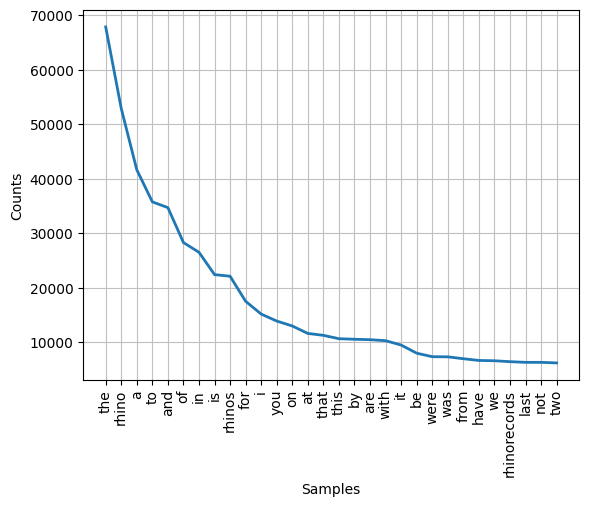

<Axes: xlabel='Samples', ylabel='Counts'>

In [22]:
# Sorted frequency plot for all words
li_token_lists_flat = [y for x in li_token_lists for y in x]  # flatten the list of token lists to a single list
print("li_token_lists_flat[:10]:", li_token_lists_flat[:10])

di_freq = nltk.FreqDist(li_token_lists_flat)
del di_freq['']
li_freq_sorted = sorted(di_freq.items(), key=lambda x: x[1], reverse=True)  # sorted list
print(li_freq_sorted)

di_freq.plot(30, cumulative=False)

[('rhino', 22117), ('get', 6853), ('last', 6527), ('rhinorecords', 6458), ('poach', 6066), ('year', 6027), ('kill', 5728), ('horn', 5328), ('park', 5280), ('national', 4618), ('amp', 4611), ('poacher', 4472), ('maskedsingeruk', 4461), ('parveenkaswan', 4402), ('indian', 4117), ('night', 4106), ('calf', 4006), ('mother', 3876), ('chitwan', 3860), ('time', 3816), ('remove', 3579), ('white', 3400), ('becaus', 3350), ('new', 3347), ('know', 3252), ('day', 3170), ('dont', 3096), ('black', 3058), ('need', 2937), ('take', 2911), ('first', 2899), ('charlie', 2880), ('see', 2879), ('make', 2747), ('say', 2714), ('republican', 2678), ('think', 2591), ('people', 2534), ('look', 2394), ('love', 2277), ('win', 2268), ('good', 2261), ('well', 2260), ('he', 2248), ('trump', 2223), ('want', 2137), ('simpson', 2123), ('go', 2111), ('game', 2076), ('democrat', 2056), ('pay', 1994), ('come', 1978), ('great', 1952), ('animal', 1938), ('elephant', 1855), ('give', 1841), ('big', 1764), ('even', 1734), ('bac

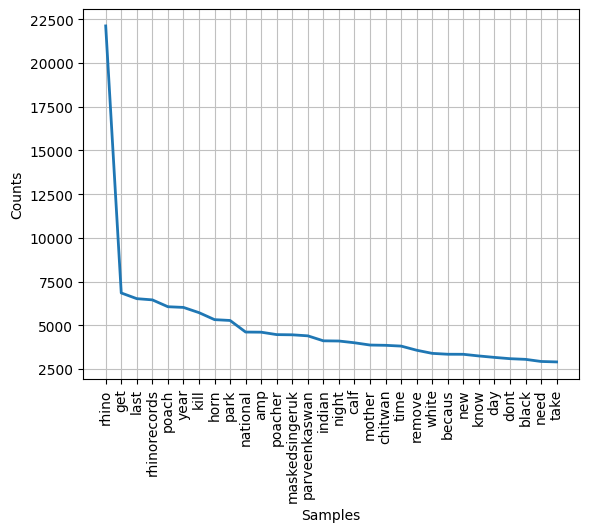

<Axes: xlabel='Samples', ylabel='Counts'>

In [23]:
# Sorted frequency plot for Lemmatized words after removing stopwords
li_lem_words = df_all_words['lem'].tolist()
di_freq2 = nltk.FreqDist(li_lem_words)
li_freq_sorted2 = sorted(di_freq2.items(), key=lambda x: x[1], reverse=True)  # sorted list
print(li_freq_sorted2)

di_freq2.plot(30, cumulative=False)